600006 600006_d6a0a2dd-3603-4e0a-a241-fd255e00b700 0.017327798783494986


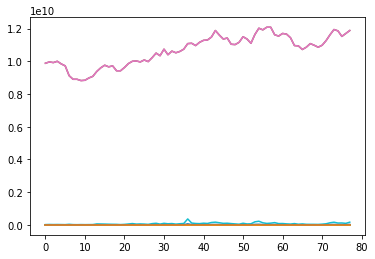

In [6]:
#!usr/bin/env python
# -*- coding:utf-8 _*-

"""
@author: solinari
@file: test.py
@time: 2019/02/10
"""

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from uuid import uuid4
import yaml

import mlflow
from pytorch.sklearn_lineregression import do_regression
from datamanager.collection import collection
from datamanager.collection import data_show
import torch
from torch.autograd import Variable
from torch_learning.tensorboardX_002 import TBwriter
from common.mongo.neteaseConn import NeteaseConn


def mlflow_log_params(conf):
    mlflow.log_param('start_date', conf['main']['start_date'])
    mlflow.log_param('end_date', conf['main']['end_date'])
    mlflow.log_param('thres', conf['collection']['thres'])
    mlflow.log_param('DBSCAN_eps', conf['collection']['sk_learn']['DBSCAN_eps'])
    mlflow.log_param('DBSCAN_minsamples', conf['collection']['sk_learn']['DBSCAN_minsamples'])

def mlflow_log_metrics():
    pass

def getStockList():
    client = NeteaseConn('D:/workspace/testproj/Conf/netease.conf')
    return client.getStocks()


def gen_training_data(code, conf):
    def gen_filename():
        filehead = str(code) + '_'
        return filehead + str(uuid4())

    def gen_storage_data(rawdata, regression_res):
        dataset = []
        dataset_info = {}

        w = regression_res[0]
        b = regression_res[1]
        score = regression_res[4]
        dataset_info['regression_w'] = w
        dataset_info['regression_b'] = b
        dataset_info['regression_score'] = score

        for _i in rawdata:
            item = []
            item.append(_i['LCLOSE'])
            item.append(_i['TOPEN'])
            item.append(_i['TCLOSE'])
            item.append(_i['HIGH'])
            item.append(_i['LOW'])
            item.append(_i['TCAP'])
            item.append(_i['MCAP'])
            item.append(_i['CHG'])
            item.append(_i['PCHG'])
            item.append(_i['VATURNOVER'])
            item.append(_i['VOTURNOVER'])
            item.append(_i['TURNOVER'])
            dataset.append(item)
        return dataset, dataset_info

    start_date = conf['main']['start_date']
    end_date = conf['main']['end_date']
    c = collection.Collection()

    for result in c.getData(code=code, start_date=start_date, end_date=end_date):
        ret = do_regression(result,
                            epochs=conf['collection']['epochs'],
                            thres=conf['collection']['thres'],
                            DBSCAN_eps=conf['collection']['sk_learn']['DBSCAN_eps'],
                            DBSCAN_minsamples=conf['collection']['sk_learn']['DBSCAN_minsamples'])
        for item in ret:
            # if line regression cov score < xx; drop this result
            if item[4] < 0.2 or abs(item[0]) < 0.01:
                continue
            dataset, dataset_info = gen_storage_data(
                rawdata=result[item[2]: item[3]], regression_res=item)

            fig = plt.figure()
            plt.plot(np.array(list(range(0, len(dataset)))),
                     np.array(dataset), label='label')

            data = pd.DataFrame(np.array(dataset))
            filehead = gen_filename()
            print(code, filehead, dataset_info['regression_w'])
#             print(data)
#                 data.to_csv('test.csv')


if __name__ == '__main__':
    mlflow.set_tracking_uri(uri="http://122.114.213.32:5000")
    
    datainfo = list()
    codes = getStockList()
    code = codes[2][0]
    with open('D:/workspace/testproj/Conf/datamanager.yaml') as f:
        conf = yaml.safe_load(f)
        
    mlflow_log_params(conf=conf)

    gen_training_data(code=code, conf=conf)